In [17]:
import numpy as np
import pandas as pd
import math
import torch
import matplotlib.pyplot as plt
import scipy
import seisbench.models as sbm

from tqdm import tqdm
from model import *
from optimizer import *
from utils import *

In [28]:
def evaluation(pred, threshold_prob, threshold_trigger, threshold_type):
    # pred: 模型預測結果, (batch_size, wave_length)
    
    # 存每個測站是否 pick 到的結果 & pick 到的時間點
    pred_isTrigger = []
    pred_trigger_sample = []
    
    for i in range(pred.shape[0]):
        isTrigger = False
        
        if threshold_type == 'single':
            a = np.where(pred[i] >= threshold_prob, 1, 0)

            if np.any(a):
                c = np.where(a==1)
                pred_isTrigger = True
                pred_trigger = c[0][0]
            else:
                pred_trigger = 0
                
        elif threshold_type == 'avg':
            a = pd.Series(pred[i])    
            win_avg = a.rolling(window=threshold_trigger).mean().to_numpy()

            c = np.where(win_avg >= threshold_prob, 1, 0)

            pred_trigger = 0
            if c.any():
                tri = np.where(c==1)
                pred_trigger = tri[0][0]-threshold_trigger+1
                isTrigger = True

        elif threshold_type == 'continue':
            pred = np.where(pred[i] >= threshold_prob, 1, 0)
           
            a = pd.Series(pred)    
            data = a.groupby(a.eq(0).cumsum()).cumsum().tolist()
          
            if threshold_trigger in data:
                pred_trigger = data.index(threshold_trigger)-threshold_trigger+1
                isTrigger = True
            else:
                pred_trigger = 0

        pred_isTrigger.append(isTrigger)
        pred_trigger_sample.append(pred_trigger)
        
    return pred_isTrigger, pred_trigger_sample

In [4]:
def z_score_standardize(data):
    new_wave = torch.empty((data.shape))

    new_wave = data - torch.mean(data, dim=1)[:, None, :]
    new_wave /= torch.std(data, dim=1)[:, None, :]
    
    if torch.any(torch.isinf(new_wave)):
        new_wave[torch.isinf(new_wave)] = 0

    if torch.any(torch.isnan(new_wave)):
        new_wave[torch.isnan(new_wave)] = 0
        
    return new_wave

In [12]:
def filter(data):
    # bandpass filter for eqtransformer
    
    filt_args = (5, [1,45], 'bandpass', False)
    sos = scipy.signal.butter(*filt_args, output="sos", fs=100)
    x = scipy.signal.sosfilt(sos, data, axis=-1)
    
    return torch.FloatTensor(x)

In [48]:
def predict(wave, model, device, threshold_prob, threshold_trigger, threshold_type):
    # zscore normalization, wave=(batch_size, wave_length, 3)
    wave = wave.permute(1,0).unsqueeze(0).to(device)

    wave = filter(wave)
    wave = z_score_standardize(wave)

    # model inference, wave=(batch_size, wave_length, 3)
    out = model(wave.permute(0,2,1))[1].squeeze()
    
    out = out.unsqueeze(0)
    
    plt.subplot(211)
    plt.plot(wave[0])
    plt.subplot(212)
    plt.plot(out[0].detach().numpy())
    plt.show()
    # 將 output 套入 threshold 做 picking
    res, pred_trigger = evaluation(out, threshold_prob, threshold_trigger, threshold_type)
    
    return res, pred_trigger

### 預測區

In [53]:
# load model
device = 'cpu'
model_path = 'tmp'

model = sbm.EQTransformer(in_samples=3000, classes=1, phases='P').to(device)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model'])

In [ ]:
# start predicting

# wave: (batch, wave_length, channels)

out = predict(wave, model, device, 0.65, 5, 'single')
out

### 測試區

In [50]:
# load waveform
import glob
import os
path = glob.glob('/mnt/nas3/earthquake_dataset_large/CWBSN/*.pt')
wave = torch.load(path[10])

torch.Size([1, 3000, 3])


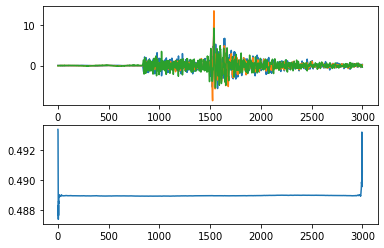

([False], [0])

In [51]:
# start predicting
out = predict(wave[:-1], model, device, 0.65, 5, 'single')
out

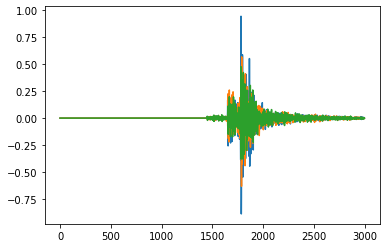

In [31]:
plt.plot(wave[:-1].T)